<a href="https://colab.research.google.com/github/Daisuke0209/box_failure_detection/blob/master/submittion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ダンボール箱不良判定プログラム


## 課題

 ダンボール製の箱の良品・不良品（ＯＫ／ＮＧ）を識別するモデルを作成すること


## 環境
本プログラムを作成するにあたり、開発環境はgoogle colaboratoryを使用しました。
また、画像データは私のGoogle Driveに保存させていただきました

（私のＰＣのスペックが低いため）


## 1.ライブラリのインポート

In [0]:
#Keras以外のライブラリ
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split

#Kerasuのライブラリ
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import random_rotation, random_shift, random_zoom
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.models import Sequential,Model
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.layers import Input, GlobalAveragePooling2D




Using TensorFlow backend.


## 2.画像データのnumpy テンソル化
元画像をそのまま使用すると、google colaboratoryでは、
おそらくメモリ不足でクラッシュ。そのため、高さ×幅＝189×252でnumpy テンソルとして
保存。

以下はGoogle colaboratoryからGoogle Driveにアクセスするための処理

In [0]:
#Google Driveのマウントを取る
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#画像データのnumpy array形式で保存
hw = {"height":189, "width":252}

os.chdir("/content/gdrive/My Drive/Datasets/")

def PreProcess(filename, hantei):
  num = 0
  arrlist = []

  files = glob.glob("/content/gdrive/My Drive/Datasets/"+hantei+"/*.JPG")

  for imgfile in files:
    img = load_img(imgfile, target_size=(hw["height"], hw["width"]))    # 画像ファイルの読み込み
    array = img_to_array(img) / 255                                     # 画像ファイルのnumpy化
    arrlist.append(array)                                               # numpy型データをリストに追加
    
    num += 1
    print(str(num)+"個のファイル読み込みに成功")
  nplist = np.array(arrlist)
  np.save(filename, nplist)
  

以下を実行すると、OK画像はOK_list_16というファイルで、NG画像はNG_list_16というファイルでGoogle Driveに保存される

In [0]:
#良品画像の保存
PreProcess("OK_list_16","OK")
#不良品画像の保存
PreProcess("NG_list_16","NG")

## 3.学習データ・テストデータの分割

### データの読み込み・分割

In [0]:
#Google Driveから画像テンソルの読み込み
#必要に応じて読み込み先を変更ください
np_NG = np.load('/content/gdrive/My Drive/Datasets/NG_list_16.npy')
np_OK = np.load('/content/gdrive/My Drive/Datasets/OK_list_16.npy')

#ラベルベクトルの作成
NG_label_1 = [1]*len(np_NG)
NG_label_2 = [0]*len(np_NG)
NG_label = np.c_[NG_label_1, NG_label_2]

OK_label_1 = [0]*len(np_OK)
OK_label_2 = [1]*len(np_OK)
OK_label = np.c_[OK_label_1, OK_label_2]


#良品/不良品画像およびラベルをまとめる
Images = np.r_[np_NG, np_OK]
labels = np.r_[NG_label, OK_label]

#random_state=0として再現性を持たせる
(X_train, X_test, y_train, y_test) = train_test_split(
  Images, labels, test_size = 0.3, random_state = 0
)

[1 0]


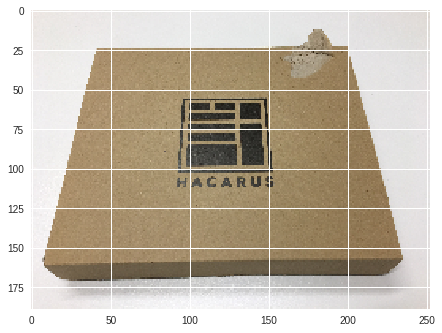

In [0]:
#画像が読めるか確認
X = X_train[0]
plt.imshow(X)
print(y_train[0])

In [0]:
#要らなくなったメモリの解放
del np_NG, np_OK, Images

## 4.モデルの作成
ダンボール箱の不良判定にはKerasを用いてCNNを実装する。CNNと一言で言っても、その実装方法は
たくさんある。今回の課題の難しいところは、与えられた画像の少なさにある。少ないデータしかない場合に、有効となるテクニックとしては以下がある。


*   Data Augmentation
*   転移学習
*   ファインチューニング

転移学習やファインチューニングでは、ImageNetなどで使用された既存のモデルを重み付きで再利用するテクニックである。
CNNにおけるネットワーク構成を完全に独自で設計しては、こういったテクニックを利用できないため、今回は既存のモデルを利用する。
既存のモデルの中でもシンプルな構成で、スペック的にそこまで高くないgoogle colaboratoryでも使用できそうなVGG-16を採用する。

今回はData Augumentation・転移学習・ファインチューニングを全て（場合によっては組み合わせて）試した。結果的には、ファインチューニングのみを用いたモデルが最も精度がよくなった。以降はVGG16+ファインチューニングによる実装を載せる


### Data Augumentation(ノイズ付与、カットアウト)
必要に応じて適宜コメントアウトを解く

In [0]:
# ガウシアンノイズ
def addGaussianNoise(src):
    row,col,ch= src.shape
    mean = 0
    var = 0.1
    sigma = 0.05
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss

    return noisy

In [0]:
def cutout(image_origin, mask_size):
    # 最後に使うfill()は元の画像を書き換えるので、コピーしておく
    image = np.copy(image_origin)
    mask_value = image.mean()

    h, w, _ = image.shape
    # マスクをかける場所のtop, leftをランダムに決める
    # はみ出すことを許すので、0以上ではなく負の値もとる(最大mask_size // 2はみ出す)
    top = np.random.randint(0 - mask_size // 2, h - mask_size)
    left = np.random.randint(0 - mask_size // 2, w - mask_size)
    bottom = top + mask_size
    right = left + mask_size

    # はみ出した場合の処理
    if top < 0:
        top = 0
    if left < 0:
        left = 0

    # マスク部分の画素値を平均値で埋める
    image[top:bottom, left:right, :].fill(mask_value)
    return image

In [0]:
# #ノイズ付与
# l = len(X_train)
# X_train_nz = np.ones(X_train.shape)
# y_train_nz = y_train

# for i in range(l):
#   X_train_nz[i] = addGaussianNoise(X_train[i])

# X_train = np.r_[X_train, X_train_nz]
# y_train = np.r_[y_train,y_train_nz]

In [0]:
# #カットアウト
# l = len(X_train)
# X_train_co = np.ones(X_train.shape)
# y_train_co = y_train

# for i in range(l):
#   X_train_co[i] = cutout(X_train[i],100)

# X_train = np.r_[X_train, X_train_co]
# y_train = np.r_[y_train,y_train_co]

### モデルの定義

In [0]:
#imagenetでの学習済み重み付きのVGG16を持ってくる
base_model = VGG16(include_top = False, weights='imagenet',input_tensor=Input(shape=(189,252,3)))

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=prediction)

#転移学習する際は、imagenetでの重み・バイアスは更新しない
# for layer in base_model.layers[:15]:
#   layer.trainable=False

model.compile(optimizer=SGD(lr=0.0003,momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 189, 252, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 189, 252, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 189, 252, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 94, 126, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 94, 126, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 94, 126, 128)      147584    
_____

### 学習の実行

In [0]:
epochs=120
his = model.fit(X_train,y_train,epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/120
261/261 [==============================] - 19s 72ms/step - loss: 0.7055 - acc: 0.4981
Epoch 2/120
261/261 [==============================] - 7s 26ms/step - loss: 0.7134 - acc: 0.5057
Epoch 3/120
261/261 [==============================] - 7s 26ms/step - loss: 0.6767 - acc: 0.5977
Epoch 4/120
261/261 [==============================] - 7s 26ms/step - loss: 0.6719 - acc: 0.5862
Epoch 5/120
261/261 [==============================] - 7s 27ms/step - loss: 0.6604 - acc: 0.5824
Epoch 6/120
261/261 [==============================] - 7s 26ms/step - loss: 0.6441 - acc: 0.7548
Epoch 7/120
261/261 [==============================] - 7s 27ms/step - loss: 0.6317 - acc: 0.7739
Epoch 8/120
261/261 [==============================] - 7s 26ms/step - loss: 0.6286 - acc: 0.6398
Epoch 9/120
261/261 [==============================] - 7s 26ms/step - loss: 0.6104 - acc: 0.6667
Epoch 10/120
261/261 [==============================] - 7s 27ms/step - loss: 0

## 5.モデルの評価
モデルの評価を行う。モデルはsoftmaxによる良品/不良品確率を出す。
例えば、モデルの出力が[0.9, 0.1]の場合は、不良品である確率が90%であるため、
不良品と判定する。
実際の良品/不良品結果と会えばスコアを+1し、テスト全体の何％が正解したか（正答率）で
評価する。

In [0]:
#スコアの表示
y = model.predict(X_test)

y_hantei = []
y_num = []

score = 0

for i in range(len(y)):
  if y[i][0]>0.5 and y_test[i][0] == 1:
    score = score+1
  elif y[i][0]<=0.5 and y_test[i][0] ==0:
    score = score + 1
  else:
    y_num.append(i)
    
print("正答率は"+str(score/len(y)*100)+"%")

正答率は99.10714285714286%


このモデルによる評価では正答率は約99%となった。
ちなみに、他のモデルでの結果は以下の通りである。全てベースのネットワークはVGG16である。


*   転移学習・ファインチューニング・Data Augumentation全て無し：97.32%
*   転移学習のみ：95.54%
*   転移学習+Data Augumentation(ノイズ付与)：94.64%
*   転移学習+Data Augumentation(カットアウト)：91.64%
*   ファインチューニング+Data Augumentation(ノイズ付与)：98.21%
*   ファインチューニング+Data Augumentation(カットアウト)：98.21%

（※：epochs数はそれぞれ異なります）

これらの結果から、ファインチューニングを用いることで最も効果的に精度を高めることができることがわかった。
（95%を越えれば、提出させて頂こうと勝手に閾値を設けました）





## 6.更なる精度向上に向けての考察

更なる精度向上を図るにはどうすればいいかを考察する。まずは、このモデルが外してしまった画像を見てみる。

In [0]:
print(y_num)
print(y_test[y_num[0]])

[94]
[0 1]


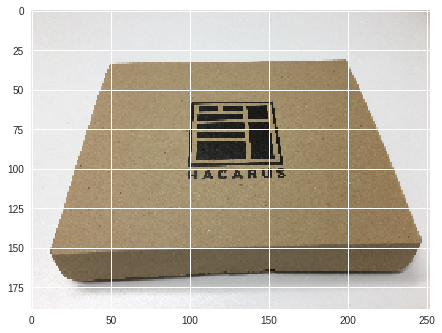

In [0]:
plt.imshow(X_test[y_num[0]])

正直なところ、この一枚だけモデルが不良と判定した理由は分からない。
さらなる精度検証を図るには、画像を圧縮させず元画像を使うか、VGGではなく
さらに精度の高いResnetなどを使用することが考えられる。そのためには、Google Colaboratoryの
開発環境では厳しく、よりスペックの高いマシンで解析を行う必要がある。